In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

# https://environment.data.gov.uk/flood-monitoring/doc/rainfall#historic-readings

N_days = 28
data_url = "https://environment.data.gov.uk/flood-monitoring/id/stations/245176TP/"
url_param = "readings.json?startdate=2022-06-01&enddate=2022-07-14&_sorted&parameter=rainfall&_limit=10000"
url = data_url+url_param

In [46]:
response = json.loads(requests.get(url).text)
data = pd.DataFrame(response['items'])

dates = data['dateTime']

data.drop(columns = ['@id','measure','dateTime'], inplace=True)
data.set_index(pd.to_datetime(dates), inplace=True)
data.head()

,value
dateTime,
2022-07-14 09:15:00+00:00,0.0
2022-07-14 09:00:00+00:00,0.0
2022-07-14 08:45:00+00:00,0.0
2022-07-14 08:30:00+00:00,0.0
2022-07-14 08:15:00+00:00,0.0


<AxesSubplot:xlabel='dateTime'>

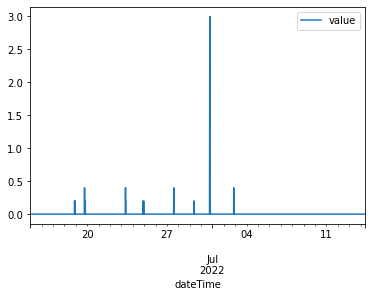

In [47]:
data.plot()